<a href="https://colab.research.google.com/github/bmccoard/AriloSprinkler-Firmware/blob/master/wave_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

running_local = False
if running_local:
    from database_util import DatabaseManager
    import talib
    file_path = '/content/drive/MyDrive/BTCUSD-5m-with-indicators.csv'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    file_path1 = '/content/drive/MyDrive/BTCUSD-5m-with-indicators.csv'
    file_path2 = '/content/drive/MyDrive/BTCUSDT-5m-with-indicators.csv'

if running_local:
    # Create an instance of the DatabaseManager
    db_manager = DatabaseManager(dbname='postgres', user='stockman', host='10.0.0.139', port=5432, password='stockman')
    db_manager.connect()
    df = db_manager.run_query("SELECT * FROM avi_Data5m WHERE ticker_id=%s ORDER BY date ASC", (db_manager.get_ticker_id('BTCUSD'),))
    df = df.drop(['id', 'ticker_id'], axis=1)

    period = 14
    # Calculate the RSI
    df['rsi'] = talib.RSI(df['close'], timeperiod=period)

    period_sma = 20
    # Calculate Simple Moving Average (SMA)
    df['sma'] = talib.SMA(df['close'], timeperiod=period_sma)
    period_ema = 100
    # Calculate Exponential Moving Average (EMA)
    df['ema'] = talib.EMA(df['close'], timeperiod=period_ema)

    # Calculate MACD
    macd, signal_line, _ = talib.MACD(df['close'])
    df['macd'] = macd
    df['macd_signal_line'] = signal_line

    # Calculate Bollinger Bands
    period_bb = 20
    df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['close'], timeperiod=period_bb)

    # Calculate Volume Oscillator
    fast_period, slow_period = 14, 28
    df['volume_oscillator'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=fast_period, timeperiod2=slow_period)

    # Close the database connection
    db_manager.close()

    # Convert 'date' to datetime and set it as the index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
else:
    # Read the CSV file1
    df = pd.read_csv(file_path1, parse_dates=['date'], index_col='date')
    df.index = pd.to_datetime(df.index, utc=True)
    # Read the CSV file2
    df2 = pd.read_csv(file_path2, parse_dates=['date'], index_col='date')
    df2.index = pd.to_datetime(df2.index, utc=True)
    print(f"Lenth BTCUSD: {len(df)}, Lenth BTCUSDT: {len(df2)} ")


print(f"From: {df.index[0]}, To: {df.index[-1]}, Price: {df.loc[df.index[0]]['close']}, To: {df.loc[df.index[-1]]['close']}")
print(f"From: {df2.index[0]}, To: {df2.index[-1]}, Price: {df2.loc[df2.index[0]]['close']}, To: {df2.loc[df2.index[-1]]['close']}")
print("Finshed!")

Mounted at /content/drive
Lenth BTCUSD: 384701, Lenth BTCUSDT: 87027 
From: 2019-09-24 13:05:00+00:00, To: 2023-05-24 03:20:00+00:00, Price: 9660.92, To: 27000.53
From: 2023-05-01 00:00:00+00:00, To: 2024-02-27 04:10:00+00:00, Price: 29298.66, To: 55793.85
Finshed!


Here I need to find impulse elliottwaves. I figure everything else is a corrective wave, but I really need an even number of corrective and impulse waves so we need to search for and parse impulse waves.

*   Issues
  * impulse waves are made up of corrective waves all the time.
  * How do we parse these, what are the rules"

*   Possible Solutions
  * just find 1-2 waves withing a window of ticks and classify that as a 1-2 setup.
  * Maybe do the same but classify 1-2, i-ii setups only and everyting else is corrective garbage whatever it is.

* Parsing Rules
  1.



For this block of code the goal is simply to parse the data into small blocks.
We will later reassemble into ellottwaves.
* The larger the window the likey higher wave degree we are in.

In [5]:
# Scan for waves multiple times based on window size.
# The larger the window the likey higher wave degree we are in
df['local_minima'] = 0
df['local_maxima'] = 0

# Set the window size for identifying local minima and maxima
window = 1000

local_minima = (df['low'].rolling(window=window, center=True).min() == df['low']).astype(int)
df['local_minima'] = local_minima
count_ones = df['local_minima'].sum()
print(f"count_ones: {count_ones}, len(df): {len(df)}, len(df_Low): {len(df['local_minima'])}")

local_maxima = (df['high'].rolling(window=window, center=True).max() == df['high']).astype(int)
df['local_maxima'] = local_maxima
count_ones = df['local_maxima'].sum()
print(f"count_ones: {count_ones}, len(df): {len(df)}, len(df_high): {len(df['local_maxima'])}")


count_ones: 280, len(df): 384701, len(df_Low): 384701
count_ones: 274, len(df): 384701, len(df_high): 384701


Post proccess small waves.

* Create other data if it helps like EMA, candels, etc.   
* Use other indicators like volume
* Use Ellottwave Rules
* Look at results for verification

The bottom line is we need to cataloge waves we can use for pattern generation.



index_0: 2020-03-01 19:00:00+00:00, index_1: 2020-03-02 22:30:00+00:00, index_2: 2020-03-07 16:35:00+00:00, index_3: 2020-03-09 15:40:00+00:00
len(subset1): 331, len(subset2): 1370, len(subset3): 566


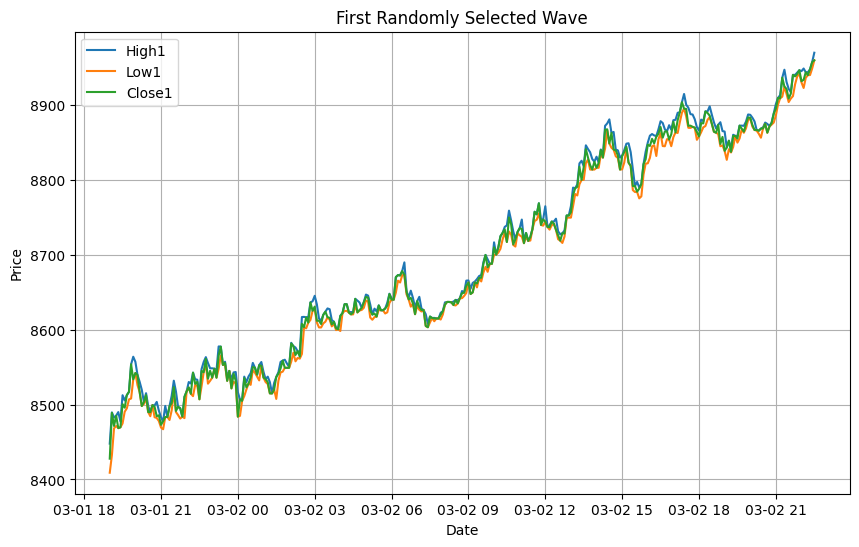

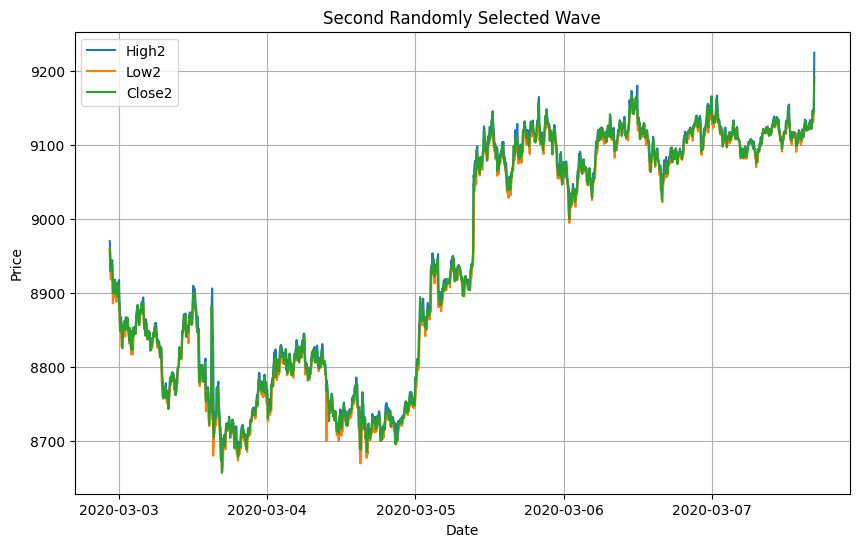

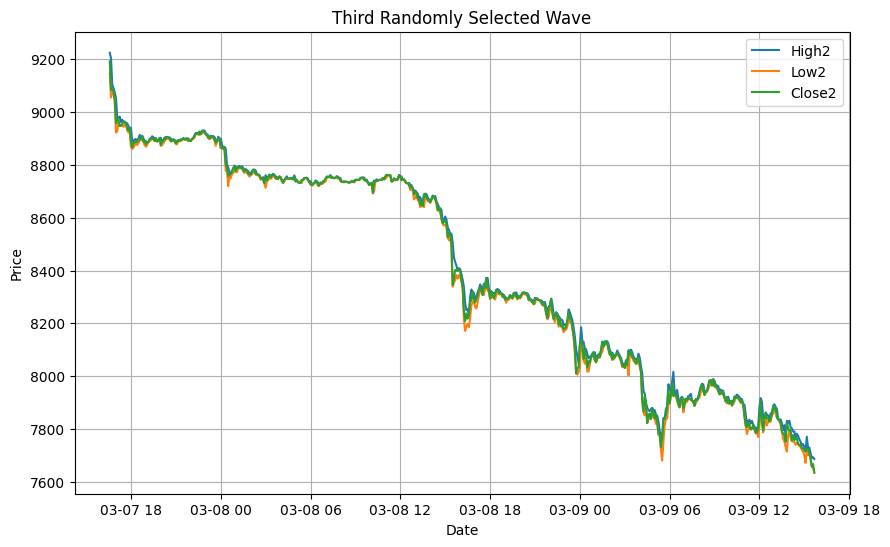

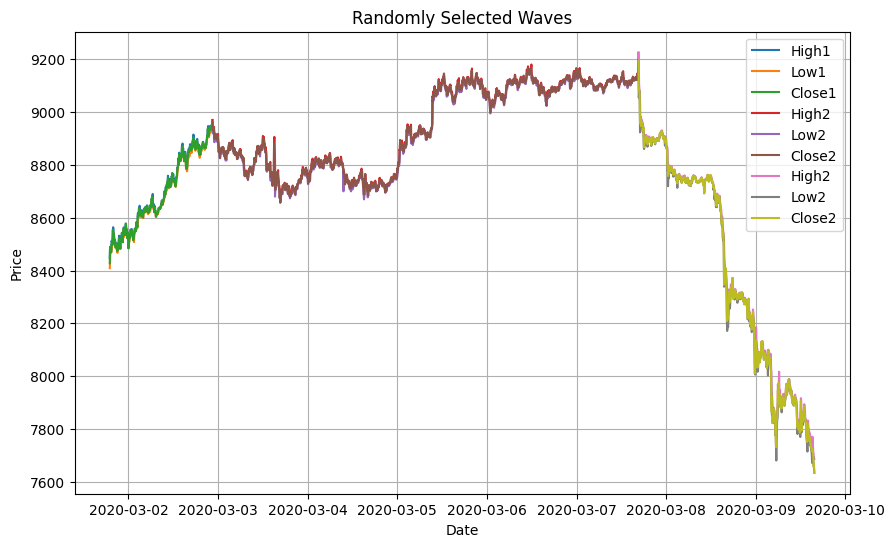

In [4]:
import matplotlib.pyplot as plt
import random

# Find indices of local minima and maxima
minima_indices = df[df['local_minima'] == 1].index
maxima_indices = df[df['local_maxima'] == 1].index

# Combine and sort the indices
all_extrema_indices = sorted(minima_indices.tolist() + maxima_indices.tolist())

# Randomly select a starting index
index_0 = random.choice(all_extrema_indices)

# Find the next three extremum indices
index_1 = None
index_2 = None
index_3 = None
found_first = False
found_second = False
for idx in all_extrema_indices:
    if idx > index_0 and not found_first:
        index_1 = idx
        found_first = True
    elif found_first and index_1 is not None and idx > index_1 and not found_second:
        index_2 = idx
        found_second = True
    elif found_second and index_2 is not None and idx > index_2:
        index_3 = idx
        break

# Print the found indices (for verification)
print(f"index_0: {index_0}, index_1: {index_1}, index_2: {index_2}, index_3: {index_3}")

if index_2:
    # Extract the subset of data
    subset1 = df.loc[index_0:index_1]
    subset2 = df.loc[index_1:index_2]
    subset3 = df.loc[index_2:index_3]

    # print subset length
    print(f"len(subset1): {len(subset1)}, len(subset2): {len(subset2)}, len(subset3): {len(subset3)}")


    # Plot the first range
    plt.figure(figsize=(10, 6))
    plt.plot(subset1.index, subset1['high'], label='High1')
    plt.plot(subset1.index, subset1['low'], label='Low1')
    plt.plot(subset1.index, subset1['close'], label='Close1')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('First Randomly Selected Wave')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the second range
    plt.figure(figsize=(10, 6))
    plt.plot(subset2.index, subset2['high'], label='High2')
    plt.plot(subset2.index, subset2['low'], label='Low2')
    plt.plot(subset2.index, subset2['close'], label='Close2')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Second Randomly Selected Wave')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the third range
    plt.figure(figsize=(10, 6))
    plt.plot(subset3.index, subset3['high'], label='High2')
    plt.plot(subset3.index, subset3['low'], label='Low2')
    plt.plot(subset3.index, subset3['close'], label='Close2')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Third Randomly Selected Wave')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Plot both together
    plt.figure(figsize=(10, 6))
    plt.plot(subset1.index, subset1['high'], label='High1')
    plt.plot(subset1.index, subset1['low'], label='Low1')
    plt.plot(subset1.index, subset1['close'], label='Close1')
    plt.plot(subset2.index, subset2['high'], label='High2')
    plt.plot(subset2.index, subset2['low'], label='Low2')
    plt.plot(subset2.index, subset2['close'], label='Close2')
    plt.plot(subset3.index, subset3['high'], label='High2')
    plt.plot(subset3.index, subset3['low'], label='Low2')
    plt.plot(subset3.index, subset3['close'], label='Close2')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Randomly Selected Waves')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Not enough extrema found.")